# TDT05 Classification - Challenge 2

## Team: 5_AI-gutta

- Magnus Schjølberg     
- Nicklas Bekkevold

## Table of contents
1. Table of contents
2. Imports and loading the data 
3. Exploratory Data Analysis (EDA)
4. Data Cleaning
5. Feature Engineering
6. Model Choice and Training
7. Prediction
8. Model Interpretation
9. Saving results to file

## TODOs

* Prøve å konvertere null-verdier til 0, og å ha null som en egen kategori
* Teste med både OHE og annen type category encoding 
* Prøve ulike 'predictors'
* Tune den beste 
* Tolke resultatene
* Plotte alle features med rikitg plot i starten

# Imports and loading the data

In [162]:
# Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from matplotlib import rcParams

print('Tensorflow version:', tf.__version__)
rcParams['figure.figsize'] = 20, 10

Tensorflow version: 2.6.0


In [163]:
# Loading the data
training_data = pd.read_csv('../input/tdt05-2021-challenge-2/challenge2_train.csv', index_col=0)
X_test = pd.read_csv('../input/tdt05-2021-challenge-2/challenge2_test.csv', index_col=0)

print('Training shape:', training_data.shape)
print('Test shape:', X_test.shape)
summary_statistics = pd.DataFrame(
    {
        'dtype': training_data.dtypes,
        'categories': training_data.nunique(),
        '#nan': training_data.isnull().sum(axis = 0),
    }, 
    index=training_data.columns,
)

print(summary_statistics)
training_data.head(5)

Training shape: (50000, 30)
Test shape: (50000, 29)
          dtype  categories   #nan
target    int64           2      0
f0      float64           2   1459
f1       object         190   1487
f2       object           6   1439
f3      float64           3   1488
f4       object           2   1498
f5      float64          13  11617
f6      float64           2   1490
f7      float64           6   1525
f8       object        2177   1490
f9       object           5   1489
f10      object          26   1501
f11     float64        7633    145
f12      object         222   1541
f13      object          15   1447
f14      object        1204   1451
f15      object         222   1477
f16     float64          12   1460
f17     float64       19209   9762
f18      object           6   1556
f19     float64           6   1437
f20     float64           4   1464
f21     float64           7   1510
f22      object           3   1513
f23      object        1495   1516
f24     float64        4148   2696
f25

,target,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28
id,,,,,,,,,,,,,,,,,,,,,
0,0,1.0,gL,e,3.0,A,NaN,0.0,6.0,96ae67d3e,...,0.5,0.0,3.0,R,328b0cf4e,0.834041,T,N,1.0,14.2364
1,0,0.0,Rj,c,1.0,A,7.0,1.0,4.0,9fcf422f2,...,0.4,0.0,1.0,NaN,328b0cf4e,0.686021,T,N,1.0,NaN
2,0,NaN,In,a,1.0,A,10.0,1.0,6.0,a5adff44e,...,0.5,1.0,3.0,G,0c67fcbbd,1.141271,T,N,3.0,NaN
3,1,1.0,rA,c,3.0,A,7.0,1.0,1.0,15c90ab2e,...,0.6,1.0,1.0,G,fee4e3007,0.662382,T,N,3.0,NaN
4,0,1.0,pE,c,3.0,A,7.0,0.0,6.0,b36490559,...,0.5,0.0,1.0,B,587e040bd,-1.000000,T,N,1.0,13.9537


In [164]:
# Configuration variables
should_convert = {
    'hexadecimal': False,
    'alphabetic': False,
    'binary': False,
    'boolean': False,
}
RANDOM_SEED = 42  # For reproducibility

# Exploratory Data Analysis (EDA)

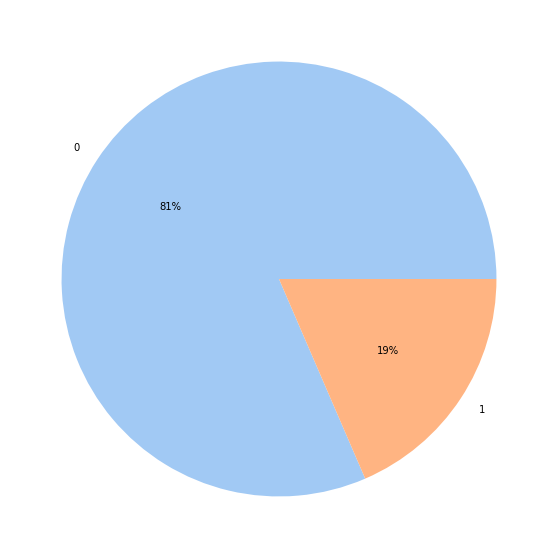

In [165]:
plt.pie(
    training_data['target'].value_counts(), 
    colors=sns.color_palette('pastel')[0:2], 
    labels=['0', '1'],
    autopct='%.0f%%',
)
plt.show()

In [166]:
# TODO plot alle features

# # numeric features with many values:
# interval_features = ['f11', 'f17', 'f24', 'f28']
# fig, axes = plt.subplots(6, 5)

# for i, feature in enumerate(interval_features):
#     ax = sns.boxplot(x=training_data[feature], ax=axes[0][i])
#     ax.set_xlabel('')
#     ax.set_ylabel(feature)

# for i, feature in enumerate(interval_features):
#     ax = sns.histplot(training_data[feature], ax=axes[1][i])
#     ax.set_xlabel(feature)
#     ax.set_ylabel('')

# fig.tight_layout()
# plt.show()

### Feature description

| Feature | Example | Note |
| :-- | :-- | :-- |
| target | 0 or 1 | This means that the problem is a binary classification |
| f0 | 0.0 or 1.0 | Binary. Could be turned into a categorical feature |
| f1 | gL, Rj, In, ... | 173 unique two letter pairs, could be country codes or something similar |
| f2 | a, b, ..., f | letters a-f |
| f3 | 1.0, 2.0 or 3.0 | ordinal of some kind, should not be converted to categorical |
| f4 | A or B | mostly As (=88%) |
| f5 | -1, 0, ..., 11 | weird distribution, many null values |
| f6 | 0 or 10 | Binary - could be turned into a categorical feature |
| f7 | 1, 2, ..., 6 | Ordinal of some kind, should not be converted to categorical |
| f8 | '96ae67d3e', 'a5adff44e' | Looks like hexadecimal, might be a hash of some kind |
| f9 | red, white, black, green, yellow | five colors |
| f10 | A, B, ..., Z | Could be converted to integers to get ordinal property |
| f11 | 139681, 140242, 142174 |  |
| f12 | '1c756c04a', '5d1ac7760' | Looks like hexadecimal, might be a hash of some kind |
| f13 | a, b, ..., o | Could be converted to integers to get ordinal property |
| f14 | '168e51823', '558613041' | Looks like hexadecimal, might be a hash of some kind |
| f15 | '7861df0a8', '1d88b0a79' | Looks like hexadecimal, might be a hash of some kind |
| f16 | 0, 10, ..., 120 | Ordinal of some kind, should not be converted to categorical |
| f17 | 858314945, 616742978 |  |
| f18 | A, B, ..., F | Could be converted to integers to get ordinal property |
| f19 | 0, 1, ..., 6 | Ordinal of some kind, should not be converted to categorical |
| f20 | 00, 01, 10 or 11 | Looks like a binary number. Could be converted to 0, 1, 2 and 3 |
| f21 | 0, 10, ..., 70 | Ordinal of some kind, should not be converted to categorical |
| f22 | R, G or B | Could it be a coincidence that it is RGB? |
| f23 | '328b0cf4e', '0c67fcbbd' | Looks like hexadecimal, might be a hash of some kind |
| f24 | 834041366, 686021137 |  |
| f25 | T or F | Binary - (T)rue or (F)alse |
| f26 | N or S | Binary - (N)orth or (S)outh? |
| f27 | 0, 1, ..., 4 | Ordinal of some kind, should not be converted to categorical |
| f28 | 141855, 139805 |  |


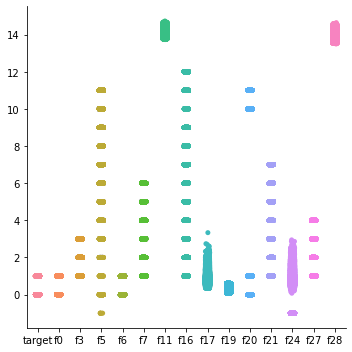

In [167]:
sns.catplot(data=training_data)
plt.show()

# Data Cleaning

# Feature engineering

## Convert (possible) hexadecimal values to decimal

In [168]:
# Convert hexadecimal numbers to decimal
hexadecimal_features = ['f8', 'f12', 'f14', 'f15', 'f23']

if should_convert['hexadecimal']: 

    func = lambda hex: int(hex, base=16)
    training_data[hexadecimal_features] = training_data[hexadecimal_features].applymap(func, na_action='ignore')
    X_test[hexadecimal_features] = X_test[hexadecimal_features].applymap(func, na_action='ignore')

    training_data[hexadecimal_features].astype(float)
    training_data[hexadecimal_features].astype(float)


In [169]:
# Plot distribution
if should_convert['hexadecimal']: 
    
    fig, axes = plt.subplots(1, len(hexadecimal_features))

    for i, feature in enumerate(hexadecimal_features):
        ax = sns.histplot(training_data[feature], ax=axes[i])
        ax.set_xlabel(feature)
        ax.set_ylabel('')

    plt.show()

## Convert binary numbers to numerical

In [170]:
# Convert binary numbers to decimal
binary_features = ['f20']  # 'f6' is automatically converted by pandas

if should_convert['binary']:

    binary_to_decimal = { 
        0.0: 0, 
        1.0: 1,
        10.0: 2,
        11.0: 3 
    }

    training_data[binary_features[0]] = training_data[binary_features[0]].map(binary_to_decimal, na_action='ignore')
    X_test[binary_features[0]] = X_test[binary_features[0]].map(binary_to_decimal, na_action='ignore')

    training_data[binary_features[0]].astype(float)
    X_test[binary_features[0]].astype(float)

    print(training_data[binary_features[0]].unique())

## Convert alphabetic characters to numbers

In [171]:
# Convert alphabetic characters to numbers: A=0, B=1, ..., Z=25
alphabetic_features = ['f2', 'f10', 'f13', 'f18']

if should_convert['alphabetic']:

    func = lambda c: ord(c.lower()) - 97
    training_data[alphabetic_features] = training_data[alphabetic_features].applymap(func, na_action='ignore')
    X_test[alphabetic_features] = X_test[alphabetic_features].applymap(func, na_action='ignore')

    training_data[alphabetic_features].astype(float)
    X_test[alphabetic_features].astype(float)

## Convert boolean features to numbers

In [172]:
# Convert boolean features to 0.0 and 1.0
boolean_mappings = {
    'f4': {'B': 0.0, 'A': 1.0},
    'f25': {'F': 0.0, 'T': 1.0},
    'f26': {'S': 0.0, 'N': 1.0},
}
boolean_features = boolean_mappings.keys()

if should_convert['boolean']:

    for feature, mapping in boolean_mappings.items():
        training_data[feature] = training_data[feature].map(mapping, na_action='ignore')
        X_test[feature] = X_test[feature].map(mapping, na_action='ignore')
        
        training_data[feature].astype(float)
        X_test[feature].astype(float)

## Decrement 'f27' down by one

f27 ranges from 1-4, we shift the scale down by one to make the range the same as f20 (0-3)

In [173]:
# decrement_by_one = lambda number: number - 1
# training_data[['f27']] = training_data[['f27']].applymap(decrement_by_one, na_action='ignore')

## Correlation plot of numeric values

We are only plotting the correlation of numeric features in this instance

In [174]:
corr_transform = training_data.copy().apply(lambda x : pd.factorize(x)[0])
corr = corr_transform.corr(method='pearson', min_periods=1)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

this method is deprecated in favour of `Styler.format(precision=..)`


,target,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28
target,1.00,0.00,0.00,0.01,-0.05,-0.05,-0.01,-0.02,0.03,0.00,-0.04,0.02,-0.01,0.01,0.05,0.00,-0.00,0.04,-0.01,0.05,-0.01,0.00,0.03,0.01,-0.00,-0.00,0.06,-0.02,0.00,-0.00
f0,0.00,1.00,-0.00,0.00,-0.01,0.00,-0.00,0.00,0.00,0.01,0.00,-0.01,0.00,-0.00,0.00,-0.00,0.01,-0.00,-0.01,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.01,-0.00,-0.00,0.00,0.01
f1,0.00,-0.00,1.00,0.00,-0.00,-0.00,-0.01,-0.00,0.00,0.01,-0.01,0.00,0.01,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.01,0.01,0.00,-0.00,0.00,-0.02,0.00,0.01
f2,0.01,0.00,0.00,1.00,-0.00,0.01,-0.01,0.01,0.00,-0.01,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.01,-0.01,0.01,-0.00,0.00,0.01,-0.00,0.01,0.00,0.00,-0.00,-0.00
f3,-0.05,-0.01,-0.00,-0.00,1.00,0.01,0.01,-0.01,0.00,-0.00,-0.00,0.00,0.00,0.01,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.01,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00
f4,-0.05,0.00,-0.00,0.01,0.01,1.00,0.00,0.01,-0.00,0.00,0.01,-0.00,0.01,-0.00,0.00,0.00,0.00,0.01,0.00,0.00,-0.00,0.01,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,0.01,0.01
f5,-0.01,-0.00,-0.01,-0.01,0.01,0.00,1.00,-0.00,0.00,0.01,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.01,-0.00,0.01,0.00,-0.00,0.01,0.00,0.00,-0.01,0.03,-0.00,-0.00,0.01,-0.01
f6,-0.02,0.00,-0.00,0.01,-0.01,0.01,-0.00,1.00,0.01,0.00,0.01,0.00,0.00,0.00,-0.01,-0.01,-0.00,-0.01,-0.00,-0.00,-0.00,0.00,0.01,0.00,-0.00,-0.00,0.01,0.00,0.00,0.00
f7,0.03,0.00,0.00,0.00,0.00,-0.00,0.00,0.01,1.00,0.00,-0.01,0.00,-0.00,-0.00,0.00,-0.00,0.01,0.00,0.01,-0.00,-0.00,-0.00,0.01,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00
f8,0.00,0.01,0.01,-0.01,-0.00,0.00,0.01,0.00,0.00,1.00,0.00,0.00,0.04,0.00,-0.01,0.02,0.00,0.00,0.03,0.01,0.01,-0.01,-0.00,-0.00,0.02,0.03,-0.00,-0.00,-0.01,0.03


<AxesSubplot:>

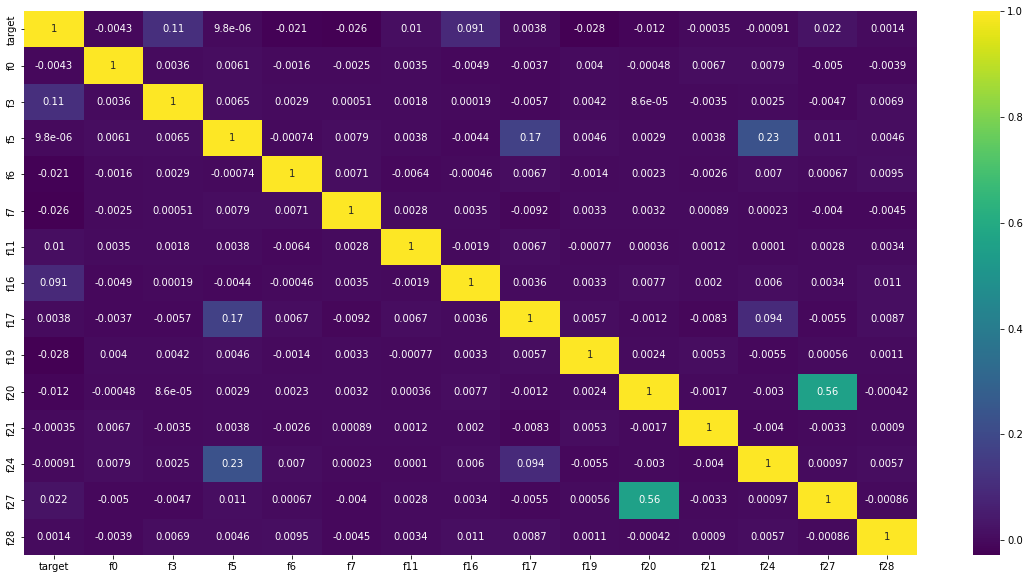

In [175]:
# Correlation plot
correlation = training_data.corr()
sns.heatmap(correlation, annot=True, cmap='viridis')

In [176]:
# Take a look at the five most correlated feature pairs
keep = np.triu(np.ones(correlation.shape), k=1).astype('bool').reshape(correlation.size)
correlation = correlation.abs().stack()[keep]  # Only use the lower triangular part of the correlation matrix
correlation = correlation.sort_values(ascending=False)[0:5]  # Only keep top 5
correlation = pd.DataFrame(correlation)
print('The five most correlated features:', correlation)

The five most correlated features:                    0
f20    f27  0.557230
f5     f24  0.231562
       f17  0.171035
target f3   0.109885
f17    f24  0.094405


The correlation plot shows that **f20** and **f27** have a very high correlation. One of these could be dropped to increase generality (and reduce the computational cost). 

The feature pairs (**f5**, **f24**) and (**f5**, **f17**) tend to increase together
We can also see that the features **f3** and **f16** have a higher correlation with the target value than others, and that we probably should somewhat focus our efforts on these.

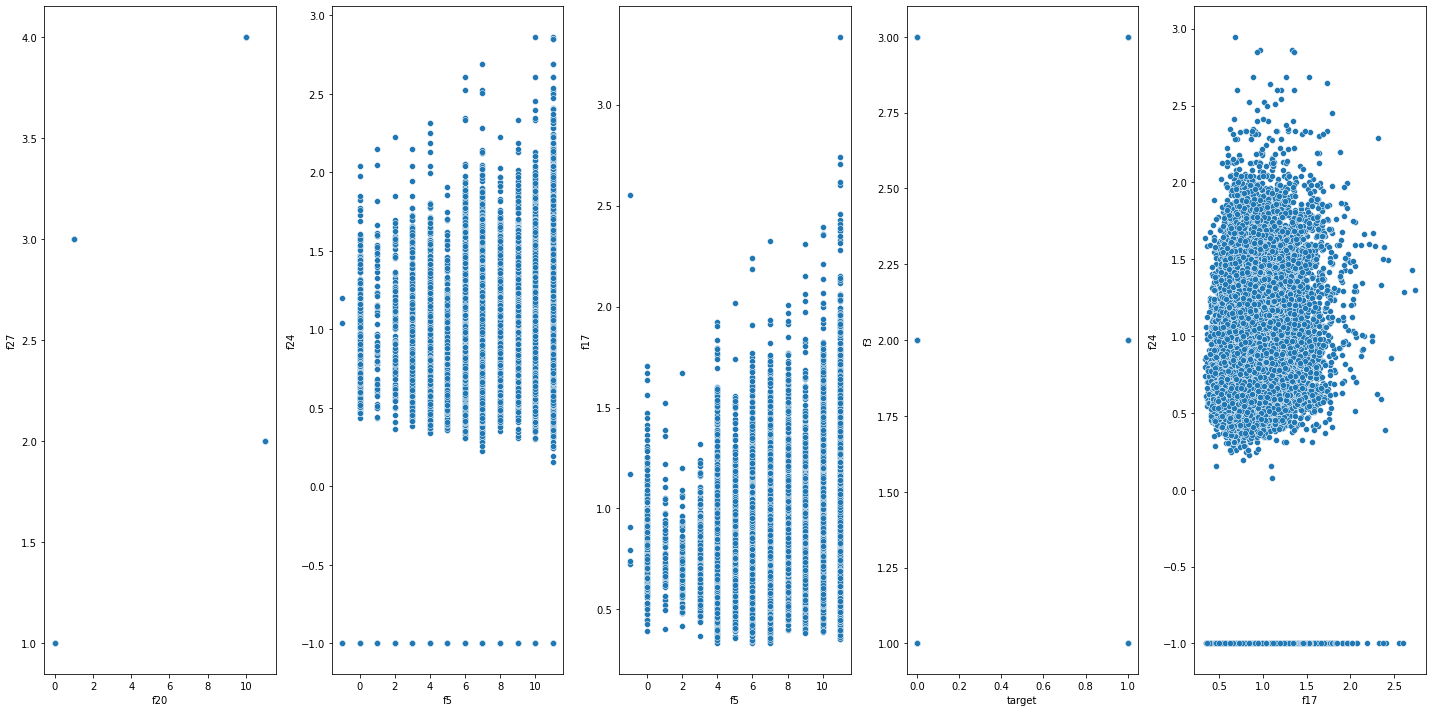

In [177]:
fig, axes = plt.subplots(1, len(correlation))

for i, (feature_x, feature_y) in enumerate(correlation.index):
    ax = sns.scatterplot(data=training_data, x=feature_x, y=feature_y, ax=axes[i])

plt.tight_layout()
plt.show()

The features labeled:
- f8 
- f12 
- f14 
- f15 
- f23

All seem to be hexadecimal. These might just be an id of sorts, or they can be the hex representation of a number.  
An idea can be to covert these into decimal and see if they are important somehow.

Or check if the number of categories increases significantly when we add the test data 

In [178]:
# Check if the number of categories increases when we add the test data 
hexadecimal_features = ['f8', 'f12', 'f14', 'f15', 'f23']
merged_datasets = pd.concat([training_data, X_test])[hexadecimal_features]

merged_statistics = pd.DataFrame(
    {
        '#categories before merge': training_data.nunique(), 
        '#categories after merge': merged_datasets.nunique(), 
    }, 
    index=merged_datasets.columns,
)

print(merged_statistics)

     #categories before merge  #categories after merge
f8                       2177                     2203
f12                       222                      222
f14                      1204                     1211
f15                       222                      222
f23                      1495                     1514


Note: 

It is peculiar that f12 and f15 have the same amount of categories =222

What could this number represent? 


## Data cleaning
Data cleaning consists of the following steps
- Removal of unwanted observations
- Fixing structural errors
- Managing unwanted outliers
- Handeling missing data

In [179]:
# Duplicate detection
training_data.duplicated().sum(axis = 0)

0

### Outlier detection and removal

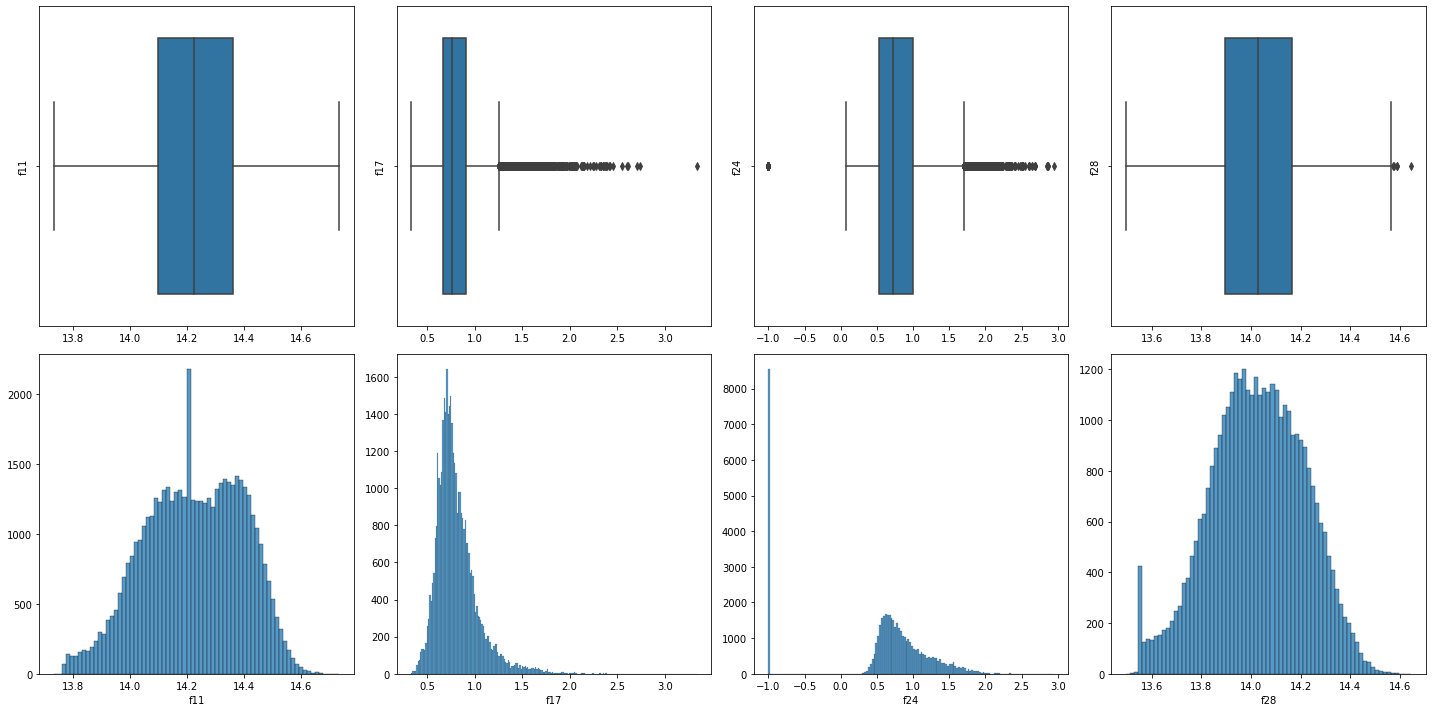

<Figure size 1440x1080 with 0 Axes>

In [180]:
# Outliers

plt.close()
# numeric features with many values:
interval_features = ['f11', 'f17', 'f24', 'f28']
fig, axes = plt.subplots(2, len(interval_features))
plt.figure(figsize=(20, 15))

for i, feature in enumerate(interval_features):
    ax = sns.boxplot(x=training_data[feature], ax=axes[0][i])
    ax.set_xlabel('')
    ax.set_ylabel(feature)

for i, feature in enumerate(interval_features):
    ax = sns.histplot(training_data[feature], ax=axes[1][i])
    ax.set_xlabel(feature)
    ax.set_ylabel('')

fig.tight_layout()
plt.show()

In [181]:
# Outlier removal by interquartile range (IQR) method

Q1 = training_data[interval_features].quantile(0.25)
Q3 = training_data[interval_features].quantile(0.75)
IQR = Q3 - Q1

# Only remove the "right tail" from the features to keep the -1 value 
training_data = training_data[~(training_data > (Q3 + 1.5 * IQR)).any(axis=1)]
training_data.shape

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


(47297, 30)

### Dealing with missing values
XBoost and CatBoost handles missing data differently. This needs to be taken into account before training.
- XGBoost: missing values should be zero
- CatBoost: missing values should be way off the distribution, like -999

In [182]:
# Partition the data
X = training_data.drop(columns=['target']).copy()
y = training_data[['target']].copy()

# Training

## CatBoost

In [183]:
# CatBoost specific preprocessing

# Imputing 
fill_value = -999 

X_catboost = X.fillna(fill_value)
X_test_catboost = X_test.fillna(fill_value)

missing_values = pd.DataFrame(
    {
        '#nan_train': training_data.isnull().sum(axis = 0),
        '#nan_test': training_data.isnull().sum(axis = 0),
    }, 
    index=training_data.columns,
)

# Check if there are any missing values left
print(missing_values)

# -----------------------------------------------------------

# Converting numerical features to categorical "strings"
categorical_numerical_features = []

if not should_convert['binary']:
    categorical_numerical_features += binary_features

if not should_convert['boolean']:
    categorical_numerical_features += ['f0', 'f6']

ordinal_features = ['f3', 'f5', 'f7', 'f16', 'f21', 'f27']
categorical_numerical_features += ordinal_features

X_catboost[categorical_numerical_features] = X_catboost[categorical_numerical_features].astype(str)
X_test_catboost[categorical_numerical_features] = X_test_catboost[categorical_numerical_features].astype(str)

# f20 have low feature importance and high correlation with f20 and can be dropped for more generality
catboost_dropped_features = ['f13']
X_catboost.drop(catboost_dropped_features, axis=1, inplace=True)
X_test_catboost.drop(catboost_dropped_features, axis=1, inplace=True)
X_catboost.head(5)

        #nan_train  #nan_test
target           0          0
f0            1393       1393
f1            1396       1396
f2            1362       1362
f3            1414       1414
f4            1413       1413
f5           10998      10998
f6            1404       1404
f7            1451       1451
f8            1419       1419
f9            1403       1403
f10           1431       1431
f11            135        135
f12           1461       1461
f13           1365       1365
f14           1382       1382
f15           1408       1408
f16           1369       1369
f17           9561       9561
f18           1461       1461
f19           1346       1346
f20           1395       1395
f21           1436       1436
f22           1433       1433
f23           1429       1429
f24           2626       2626
f25           1463       1463
f26           1385       1385
f27           1395       1395
f28          12416      12416


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,gL,e,3.0,A,-999.0,0.0,6.0,96ae67d3e,yellow,...,0.5,0.0,3.0,R,328b0cf4e,0.834041,T,N,1.0,14.2364
1,0.0,Rj,c,1.0,A,7.0,1.0,4.0,9fcf422f2,green,...,0.4,0.0,1.0,-999,328b0cf4e,0.686021,T,N,1.0,-999.0000
2,-999.0,In,a,1.0,A,10.0,1.0,6.0,a5adff44e,white,...,0.5,1.0,3.0,G,0c67fcbbd,1.141271,T,N,3.0,-999.0000
3,1.0,rA,c,3.0,A,7.0,1.0,1.0,15c90ab2e,yellow,...,0.6,1.0,1.0,G,fee4e3007,0.662382,T,N,3.0,-999.0000
4,1.0,pE,c,3.0,A,7.0,0.0,6.0,b36490559,yellow,...,0.5,0.0,1.0,B,587e040bd,-1.000000,T,N,1.0,13.9537


In [184]:
# Utility function to go from, e.g. 'f10' to 10
def features_to_indices(features):
    return [int(column.replace('f', '')) for column in features]

In [185]:
# Utility function to go from, e.g. 10 to 'f10
def indices_to_features(indices):
    return [f'f{index}' for index in indices]

In [186]:
# Utility function for computing the new indices after dropping certain columns
def indices_after_droping(indices, dropped_columns):
    updated_indices = list(indices)
    dropped_indices = features_to_indices(dropped_columns)
    
    for i, old_index in enumerate(indices):
        for column_index in dropped_indices:
            if old_index >= column_index:
                updated_indices[i] -= 1

    return updated_indices

In [187]:
# Find out which features are categorical before training
categorical_features_indices = [1, 9, 22]
categorical_features_indices += features_to_indices(ordinal_features)

if not should_convert['hexadecimal']:
    categorical_features_indices += features_to_indices(hexadecimal_features)

if not should_convert['alphabetic']:
    categorical_features_indices += features_to_indices(alphabetic_features)

if not should_convert['binary']:
    categorical_features_indices += features_to_indices(binary_features)

if not should_convert['boolean']:
    categorical_features_indices += features_to_indices(boolean_features)
    categorical_features_indices += features_to_indices(['f0', 'f6'])

categorical_features_indices = sorted(categorical_features_indices)
print('Categorical features:', categorical_features_indices)

Categorical features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 25, 26, 27]


In [188]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# X_train, X_validation, y_train, y_validation = train_test_split(X_catboost, y, train_size=0.8, random_state=42)

catboost_dropped_indices = features_to_indices(catboost_dropped_features)
categorical_features_indices = [index for index in categorical_features_indices if index not in catboost_dropped_indices]
categorical_features_indices_after_dropping = indices_after_droping(categorical_features_indices, catboost_dropped_features)
print(categorical_features_indices_after_dropping)

catboost_model = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=RANDOM_SEED,
    logging_level='Silent'
)

catboost_model.fit(
    X_catboost, y,
    cat_features=categorical_features_indices_after_dropping
)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 17, 19, 20, 21, 22, 24, 25, 26]


In [189]:
# # CatBoost with regressor
# from catboost import CatBoostRegressor, Pool, metrics, cv
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# X_train, X_validation, y_train, y_validation = train_test_split(X_catboost, y, train_size=0.8, random_state=42)

# catboost_model = CatBoostRegressor(
#     random_seed=RANDOM_SEED,
#     logging_level='Silent'
# )

# catboost_model.fit(
#     X_train, y_train,
#     cat_features=categorical_features_indices_after_dropping,
#     eval_set=(X_validation, y_validation),
#     early_stopping_rounds=10,
#     plot=True
# )

# cv_params = catboost_model.get_params()
# cv_params.update({
#     'loss_function': metrics.Logloss()
# })

# cv_data = cv(
#     Pool(X_train, y_train, cat_features=categorical_features_indices_after_dropping),
#     cv_params,
#     plot=True
# )

In [190]:
# # Stacking several CatBoosts 
# from sklearn.linear_model import LogisticRegression
# from mlxtend.classifier import StackingCVClassifier

# classifiers = [
#     CatBoostClassifier(
#         cat_features=categorical_features_indices_after_dropping,
#         random_seed=RANDOM_SEED,
#         logging_level='Silent'
#     ),
#     CatBoostRegressor(
#         cat_features=categorical_features_indices_after_dropping,
#         random_seed=RANDOM_SEED,
#         logging_level='Silent'
#     ),
# ]
# meta_classifier = LogisticRegression()

# stacking_model = StackingCVClassifier(classifiers=classifiers, meta_classifier=meta_classifier)

Accuracy: 82.87%


<AxesSubplot:xlabel='feature_importance'>

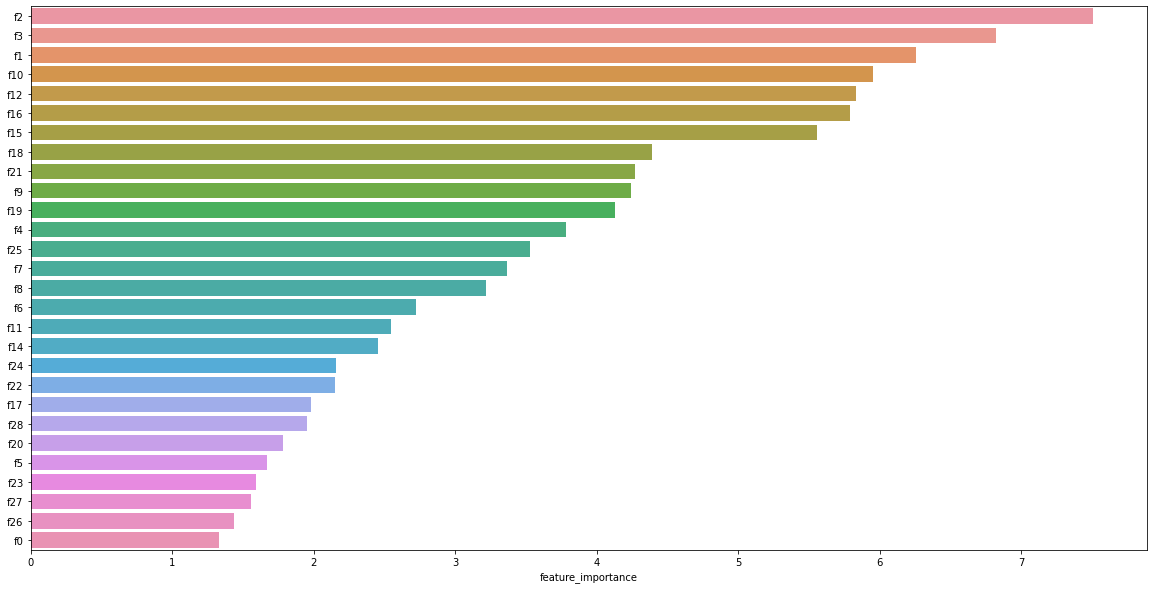

In [191]:
accuracy = catboost_model.get_best_score()['learn']['Accuracy']
print(f'Accuracy: {accuracy * 100:.2f}%')

feature_importance = pd.DataFrame({'feature_importance': catboost_model.get_feature_importance()}, index=X_catboost.columns)
feature_importance.sort_values(by='feature_importance', ascending=False, inplace=True)
sns.barplot(data=feature_importance, x='feature_importance', y=feature_importance.index)

## XGBoost 

In [192]:
# # XGBoost requires only numerical features
# # One-hot encode all categorical features
# categorical_features = indices_to_features(categorical_features_indices)
# print(categorical_features_indices)

# X_xgboost = pd.get_dummies(X, columns=categorical_features)
# X_test_xgboost = pd.get_dummies(X_test, columns=categorical_features)

In [193]:
# from xgboost import XGBClassifier

# xgboost_model = XGBClassifier()
# xgboost_model.fit(X_xgboost, y)

# predictions = xgboost_model.predict(X_xgboost)
# accuracy = accuracy_score(y, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Hyper parameter tuning (CatBoost)

In [194]:
# List all parameters for CatBoost classifier
#CatBoostClassifier?

In [195]:
# from catboost import CatBoostClassifier, metrics
# from sklearn.model_selection import RandomizedSearchCV

# catboost_model = CatBoostClassifier(
#     random_seed=42,
#     logging_level='Silent'
# )

# hyperparameters = {
#     'iterations': [100, 150, 200],
#     'learning_rate': [0.03, 0.1],
#     'depth': [2, 4, 6, 8],
#     'l2_leaf_reg': [0.2, 0.5, 1, 3]
# }

# catboost_hyperparameters = RandomizedSearchCV(
#     estimator=catboost_model, 
#     param_distributions=hyperparameters, 
#     n_iter=100, 
#     scoring='neg_mean_absolute_error', 
#     cv=3, 
#     verbose=2, 
#     random_state=42, 
#     n_jobs=-1,
#     return_train_score=True
# )

# catboost_hyperparameters.fit(X_catboost, y)

In [196]:
# catboost_hyperparameters.best_params_

# Model interpretation

Using a SHapley Additive exPlanations (SHAP) plot to assign an importance value to each feature for a given prediction.

In [197]:
# sorted_feature_importance = catboost_model.get_feature_importance().argsort()
# explainer = shap.TreeExplainer(catboost_model)
# shap_values = explainer.shap_values(X_test_catboost)
# shap.summary_plot(shap_values, X_test_catboost, feature_names=feature_importance.index, max_display=X_test_catboost.shape[1])

In [198]:
#shap.dependence_plot("f2", shap_values, X_catboost)

In [199]:
# # confusion matrix
# from sklearn.metrics import ConfusionMatrixDisplay
# ConfusionMatrixDisplay

## Make predictions

Make predictions from `X_test` and save to file.

In [200]:
# CatBoost
y_pred = catboost_model.predict(X_test_catboost, prediction_type='Probability')
predictions = pd.DataFrame({'id': X_test_catboost.index, 'target': y_pred[:,1]})

predictions.to_csv('../output/catboost.txt', index=False)


# # XGBoost
# y_pred = xgboost_model.predict_proba(X_test_xgboost)
# predictions = pd.DataFrame({'id': X_test_xgboost.index, 'target': y_pred[:,1]})

# predictions.to_csv('../output/xgboost.txt', index=False)

## One-hot encoding
The features labeled:
- f0 (Boolean)
- f1
- f2
- f4
- f9
- f10
- f13
- f18
- f22
- f25 (Boolean)
- f26 (Boolean)

Toghether with the hex features discussed above:
- f8 
- f12 
- f14 
- f15 
- f23


All seem to be categorical and should therefore be converted to one-hot encoding (depending on the learning algorithm).

In [201]:
# One-hot encode categorical features
categorical_features = ['f0', 'f1', 'f2', 'f4', 'f8', 'f9', 'f10', 'f12', 'f13', 'f14', 'f15', 'f18', 'f22', 'f23', 'f25', 'f26']

X_encoded = pd.get_dummies(X, columns=categorical_features)
X_encoded.head()

,f3,f5,f6,f7,f11,f16,f17,f19,f20,f21,...,f23_feea951a9,f23_fef019413,f23_ff6da8268,f23_ff8d3215a,f23_ffe6f54c2,f23_fff06aa8f,f25_F,f25_T,f26_N,f26_S
id,,,,,,,,,,,,,,,,,,,,,
0,3.0,NaN,0.0,6.0,13.9681,2.0,0.858315,0.5,0.0,3.0,...,0,0,0,0,0,0,0,1,1,0
1,1.0,7.0,1.0,4.0,14.0242,NaN,0.616743,0.4,0.0,1.0,...,0,0,0,0,0,0,0,1,1,0
2,1.0,10.0,1.0,6.0,14.2174,3.0,0.711389,0.5,1.0,3.0,...,0,0,0,0,0,0,0,1,1,0
3,3.0,7.0,1.0,1.0,13.8536,5.0,NaN,0.6,1.0,1.0,...,0,0,0,0,0,0,0,1,1,0
4,3.0,7.0,0.0,6.0,14.2347,2.0,0.572781,0.5,0.0,1.0,...,0,0,0,0,0,0,0,1,1,0


In [202]:
# plt.figure(figsize=(32, 12))
# sns.heatmap(training_data.corr(), annot=True, cmap='viridis')

In [203]:
def grade(number_of_vts_beaten):
    a = (100 - 41) / (10 - 1)
    b = 41
    return a * (number_of_vts_beaten - 1) + b

print(grade(7))

# 7 = C
# 8 = B

80.33333333333333
